# Forward rate analysis with DI-1 futures
## Author: Gustavo Soares

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Get the DI-1 curve

Let's use [FinanceHub's DB Connect and DI1 classes](https://github.com/Finance-Hub/FinanceHub/tree/master/dataapi/AWS) to grab the data for a particular date.

By running the commands below, we connected to FinanceHub's AWS database and grabbed time series data for DI-1 futures which are stored under the attribute ```time_series``` of the ```DI1``` class:

In [2]:
from dataapi import DBConnect, DI1
dbc = DBConnect('fhreadonly', 'finquant')
di = DI1(dbc)

In [3]:
di.time_series.tail()

open_interest_open  open_interest_close  \
time_stamp maturity_code                                            
2021-01-29 V23                         52680                52790   
           V24                         32175                32175   
           V25                         16273                16273   
           X21                         65645                65585   
           Z21                         47910                48005   

                          number_of_trades  trading_volume  financial_volume  \
time_stamp maturity_code                                                       
2021-01-29 V23                          32             410          35428936   
           V24                           0               0                 0   
           V25                           0               0                 0   
           X21                           7            1160         113472352   
           Z21                          13             935          91131875   

                          previous_settlement  indexed_settlement  \
time_stamp maturity_code                                            
2021-01-29 V23                       86240.63            86240.63   
           V24                       79801.54            79801.54   
           V25                       73646.91            73646.91   
           X21                       97781.83            97781.83   
           Z21                       97424.40            97424.40   

                          opening_price  minimum_price  maximum_price  \
time_stamp maturity_code                                                
2021-01-29 V23                    5.660          5.585          5.665   
           V24                    0.000          0.000          0.000   
           V25                    0.000          0.000          0.000   
           X21                    2.980          2.980          2.990   
           Z21                    3.145          3.135          3.160   

                          average_price  last_price  settlement_price  \
time_stamp maturity_code                                                
2021-01-29 V23                    5.637       5.585          86525.37   
           V24                    0.000       0.000          80214.50   
           V25                    0.000       0.000          74099.25   
           X21                    2.981       2.980          97821.73   
           Z21                    3.141       3.160          97470.01   

                          last_bid  last_offer  
time_stamp maturity_code                        
2021-01-29 V23               5.585        5.60  
           V24               6.210        6.24  
           V25               0.000        0.00  
           X21               0.000        0.00  
           Z21               0.000        3.15

For our forward rate analysis, we are only really interested in the curve for one particular date, so let's grab just the latest curve:

In [4]:
ref_date = di.time_series.index.max()[0]
di_curve = di.time_series.loc[ref_date, 'last_price']
di_curve.tail()

maturity_code
V23    5.585
V24    0.000
V25    0.000
X21    2.980
Z21    3.160
Name: last_price, dtype: float64

Let's replace the contract codes by its actual expires, remove the zeros and plot our curve:

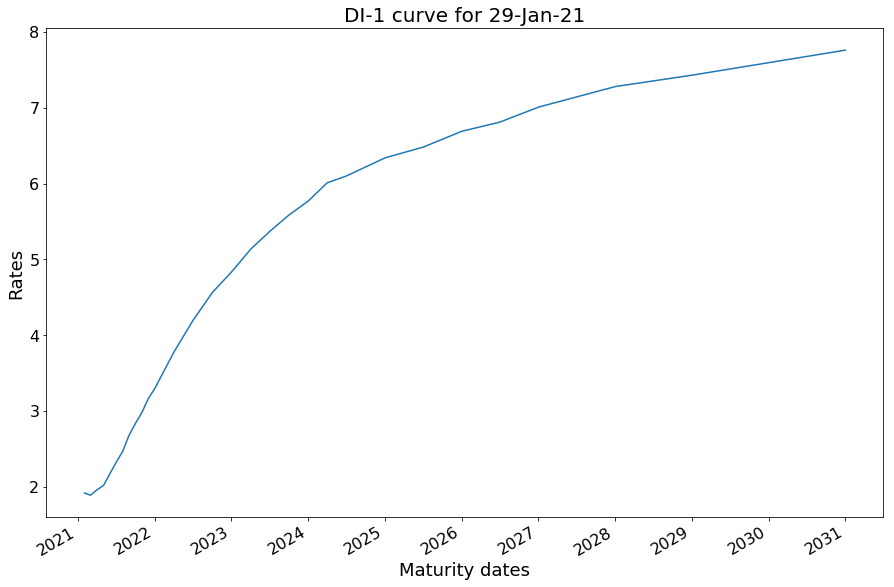

In [5]:
di_curve.index = [di.maturity(x) for x in di_curve.index]
di_curve = di_curve[di_curve>0.].sort_index()
di_curve.plot(figsize=(15,10), fontsize=16)
plt.title('DI-1 curve for %s' % ref_date.strftime('%d-%b-%y'), fontsize=20)
plt.xlabel('Maturity dates', fontsize=18)
plt.ylabel('Rates', fontsize=18)
plt.show()

Let's save the curve in a .csv file.

In [6]:
di_curve.to_csv('di1_curve_%s.csv' % ref_date.strftime('%y%m%d'))

If you prefer, you can just upload that file and start the notebook from here!

In [7]:
di_curve = pd.read_csv('di1_curve_%s.csv' % ref_date.strftime('%y%m%d'), index_col=0).astype(float)
di_curve.index = pd.to_datetime(di_curve.index)

# Forward rates

The forward rate betweem dates $t_{1}$ and $t_{2}$, assuming they are expressed in years, is defined as:

$$
f(t_{1},t_{2}) \equiv \Big[\frac{(1+y_{t_{2}})^{t_{2}}}{(1+y_{t_{1}})^{t_{1}}}\Big]^{\frac{1}{t_{2}-t_{1}}}-1
$$

where $y_{t_{1}}$ and $y_{t_{2}}$ are the zero-coupon rates for dates $t_{1}$ and $t_{2}$. The forward rate $f(t_{1},t_{2})$ is defined in a way that is the implicit rate prevailing between dates $t_{1}$ and $t_{2}$ that will satisfy the no-arbitrage condition:

$$
(1+y_{t_{1}})^{t_{1}}[1+f(t_{1},t_{2})]^{t_{2}-t_{1}} \equiv (1+y_{t_{2}})^{t_{2}}
$$

Suppose we want to find out the 1 month rate is 1 year forward, then we can use [FinanceHub's curve models](https://github.com/Finance-Hub/FinanceHub/blob/master/finmath/termstructure/curve_models.py) to calculate the 1y1m forward rate: 

In [8]:
from finmath import curve_models
t1 = 1.
t2 = 1. + 1./.12
zero_curve = pd.Series([x/100. for x in di_curve.values],
                       [di.dc.days(ref_date, x)/252 for x in di_curve.index]).astype(float)
curve_models.forward_rate(t1, t2, zero_curve)

0.08197868249075513

# Locking in forward rates

What would happen if we thought that short-term rates would realized above the forward rate, $f(t_{1},t_{2})$, over the period between $t_{1}$ and $t_{2}$?

Then for any trade notional $N$, we could get into the following trade:

* Sell $q_{1}=N/100000$ DI-1 futures contracts (i.e., buying PU and selling rates) at the prevailing rate $y_{t_{1}}$, i.e, at $PU_{t_{1}} = 100000(1+y_{t_{1}})^{-t_{1}}$
* Buy $q_{2}=q_{1}PU_{t_{1}}/PU_{t_{2}}$ DI-1 futures contracts (i.e., selling PU and buying rates) at the prevailing rate $y_{t_{2}}$, i.e, at $PU_{t_{2}} = 100000(1+y_{t_{2}})^{-t_{2}}$

Let's define the function that tracks the realization of the short term rate (for DI-1 futures that is the CDI rate) between two periods $t$ and $s>t$ as:

$$
CDI(t, s) = \prod_{i=t+1}^{s}(1+r_{i})^{\frac{1}{252}}
$$

### Leg 1 in $t_{1}$

The profit (or loss) from the first position would be:

$$
q_{1} \times (100000 - PU_{t_{1}}CDI(0, t_{1}))
$$

where $CDI(0, t_{1})$ is the realization of the short term rate (CDI) from now, $t=0$, until $t_{1}$:

$$
CDI(0, t_{1}) = \prod_{i=1}^{t_{1}}(1+r_{i})^{\frac{1}{252}}
$$

### Leg 2 in $t_{1}$

The profit (or loss) from the second position would be:

$$
-q_{2} \times (PU_{t_{1}, t_{2}} - PU_{t_{2}}CDI(0, t_{1}))
$$

where $PU_{t_{1}, t_{2}-t_{1}}$ is the price of a contract maturing in $t_{2}$ at time $t_{1}$. Currently, $t=0$, this value is unknown and it will depend on what the prevailing rate $y_{t_{1}, t_{2}-t_{1}}$ will be in that point in time, $t_{1}$.

Note that the value above is equal to:

$$
-q_{1} \times (\frac{ PU_{t_{1}, t_{2}-t_{1}} PU_{t_{1}}}{PU_{t_{2}}} - PU_{t_{1}}CDI(0, t_{1}))
$$

### Both legs in $t_{1}$

Both legs together then give us the total profit or loss in $t_{1}$ of:

$$
q_{1} \times (100000 - \frac{ PU_{t_{1}, t_{2}-t_{1}} PU_{t_{1}}}{PU_{t_{2}}})
$$

### Between $t_{1}$ and $t_{2}$

The profit or loss above will either earn or pay interest at the short-term rate realization between $t_{1}$ and $t_{2}$, generating a final profit or loss at $t_{2}$ of:

$$
q_{1} \times (100000 - \frac{PU_{t_{1}, t_{2}-t_{1}}PU_{t_{1}}}{PU_{t_{2}}}) \times CDI(t_{1}, t_{2})
$$

where $CDI(t_{1}, t_{2})$ is the realization of the short term rate (CDI) from now, $t_{1}$, until $t_{2}$:

$$
CDI(t_{1}, t_{2}) = \prod_{i=t_{1}+1}^{t_{2}}(1+r_{i})^{\frac{1}{252}}
$$

Now, note that from $t_{1}$ until $t_{2}$ the second leg of the trade will generate the pnl:

$$
-q_{2} \times (100000 - PU_{t_{1}, t_{2}-t_{1}}CDI(t_{1}, t_{2})) = \\
-q_{1}\frac{PU_{t_{1}}}{PU_{t_{2}}} \times (100000 - PU_{t_{1}, t_{2}-t_{1}}CDI(t_{1}, t_{2})) = \\
$$

Therefore, the full profit or loss is the sum of the two terms above which is actually equal to:

$$
N \times (CDI(t_{1}, t_{2}) - \frac{PU_{t_{1}}}{PU_{t_{2}}}) = \\
N \times (CDI(t_{1}, t_{2}) - \frac{(1+y_{t_{2}})^{t_{2}}}{(1+y_{t_{1}})^{t_{1}}}) = \\
N \times (CDI(t_{1}, t_{2}) - (1+f(t_{1},t_{2}))^{t_{2}-t_{1}})
$$

What the result above just showed is that this trade would generate a profit if the short-term rates would realize, $CDI(t_{1}, t_{2})$, above the forward rate, $f(t_{1},t_{2})$ over the period between $t_{1}$ and $t_{2}$.

# Forward curve

Since $f(t_{1},t_{2})$ gives us an achor against which we can build our expectations regarding the realization the short-term rates in the period. Let's see how we can backout an implicit tragectory for the short term rate from the forward rates.

The Brazilian Central Bank will meet (COPOM) in the following dates to decide the prevailing level of the short-term interest rates. We can use [FinanceHub's curve models](https://github.com/Finance-Hub/FinanceHub/blob/master/finmath/termstructure/curve_models.py) to find out what the interpolated DI-1 rate would be for those dates:

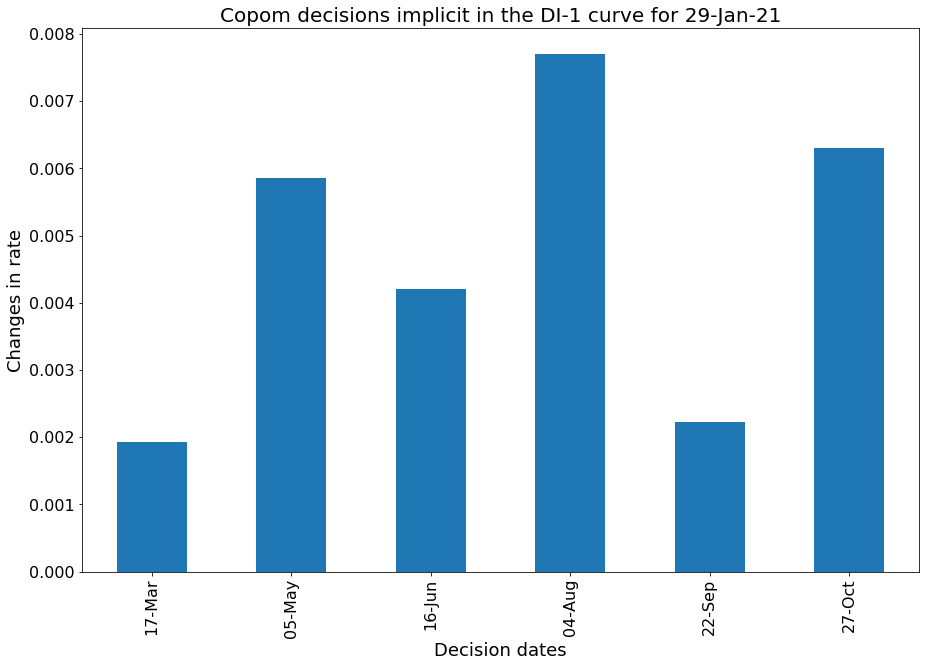

In [9]:
copom_meets = [
    pd.to_datetime('2021-03-17'),
    pd.to_datetime('2021-05-05'),
    pd.to_datetime('2021-06-16'),
    pd.to_datetime('2021-08-04'),
    pd.to_datetime('2021-09-22'),
    pd.to_datetime('2021-10-27'),
    pd.to_datetime('2021-12-08'),

]

copom_t = [di.dc.days(ref_date, x)/252 for x in copom_meets]
copom_y = [curve_models.flat_forward_interpolation(t, zero_curve) for t in copom_t]
copom_rates = pd.Series(copom_y, copom_t)
copom_fwd_rates = [curve_models.forward_rate(copom_rates.index[i-1], copom_rates.index[i], zero_curve)
                                                for i in range(1, len(copom_rates))]
copom_fwd_rates = pd.Series([copom_y[0]] + copom_fwd_rates, [x.strftime('%d-%b') for x in copom_meets])
implicit_copom_decision = copom_fwd_rates.diff(1).shift(-1).dropna()

implicit_copom_decision.plot(figsize=(15,10), kind='bar', fontsize=16)
plt.title('Copom decisions implicit in the DI-1 curve for %s' % ref_date.strftime('%d-%b-%y'),
          fontsize=20)
plt.xlabel('Decision dates', fontsize=18)
plt.ylabel('Changes in rate', fontsize=18)
plt.show()

Let's suppose now we have a scenario for copom decisions and we want to compare with what is implicit in the DI-1 curve.

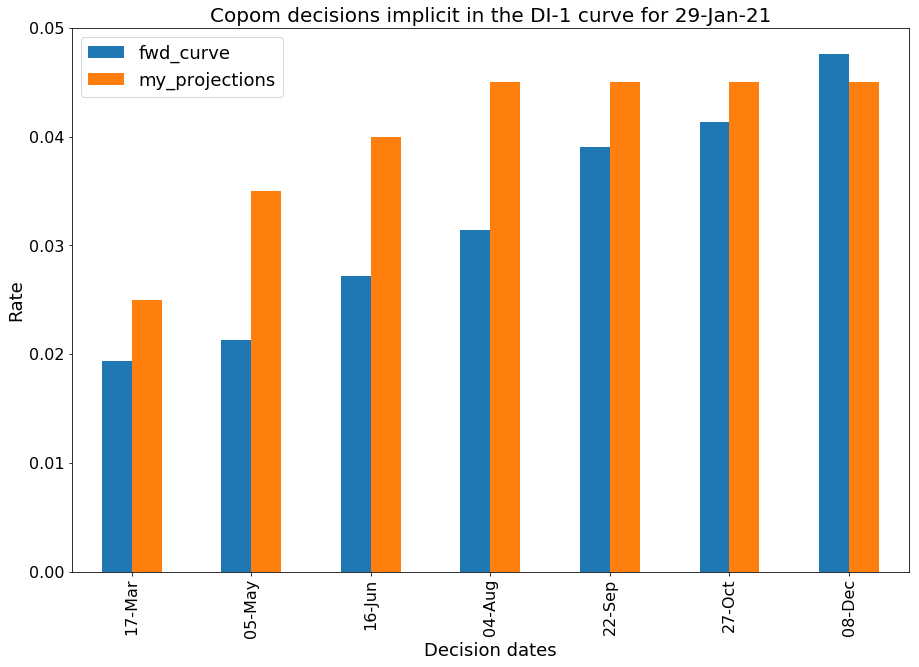

In [10]:
my_projections = pd.Series(
[
    2.50,    
    3.50, 
    4.00, 
    4.50,
    4.50,
    4.50,
    4.50    
], copom_fwd_rates.index).to_frame('my_projections')

df = pd.concat([copom_fwd_rates.to_frame('fwd_curve'), my_projections/100.], axis=1)
df.plot(figsize=(15,10), kind='bar', fontsize=16)
plt.title('Copom decisions implicit in the DI-1 curve for %s' % ref_date.strftime('%d-%b-%y'),
          fontsize=20)
plt.xlabel('Decision dates', fontsize=18)
plt.ylabel('Rate', fontsize=18)
plt.legend(fontsize=18)
plt.show()

In the chart above, we can see that we are projecting higher realized rates for the short-term rate than what's implicit in the forward curve. Hence, this suggests that, for any trade notional $N$, we could profit by getting into a trade of the type:

* Buy $q_{1}=N/100000$ DI-1 futures contracts (i.e., selling PU and buying rates) at the prevailing rate $y_{t_{1}}$, i.e, at $PU_{t_{1}} = 100000(1+y_{t_{1}})^{-t_{1}}$
* Buy $q_{2}=q_{1}PU_{t_{1}}/PU_{t_{2}}$ DI-1 futures contracts (i.e., selling PU and buying rates) at the prevailing rate $y_{t_{2}}$, i.e, at $PU_{t_{2}} = 100000(1+y_{t_{2}})^{-t_{2}}$

Here, we could choose, for example, $t_{1}=2021, Mai, 03$ by using the DI-1 K21 contract and $t_{2}=2021, Aug, 02$ by using the DI-1 Q21 contract.